In [1]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostClassifier


import warnings

# 경고 무시
warnings.filterwarnings("ignore", category=FutureWarning)

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 예시로 'NanumGothic'을 사용

In [14]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [15]:
train = train.drop(['ID'], axis=1)


In [16]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,36 months,10+ years,MORTGAGE,210000000,9.33,33,신용 카드,0,974580,492168.0,0.0,0.0,C
96290,28800000,60 months,10+ years,MORTGAGE,132000000,5.16,25,주택 개선,0,583728,855084.0,0.0,0.0,E
96291,14400000,36 months,1 year,MORTGAGE,84000000,11.24,22,신용 카드,0,1489128,241236.0,0.0,0.0,A
96292,15600000,36 months,5 years,MORTGAGE,66330000,17.30,21,부채 통합,2,1378368,818076.0,0.0,0.0,D


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   대출금액          96294 non-null  int64  
 1   대출기간          96294 non-null  object 
 2   근로기간          96294 non-null  object 
 3   주택소유상태        96294 non-null  object 
 4   연간소득          96294 non-null  int64  
 5   부채_대비_소득_비율   96294 non-null  float64
 6   총계좌수          96294 non-null  int64  
 7   대출목적          96294 non-null  object 
 8   최근_2년간_연체_횟수  96294 non-null  int64  
 9   총상환원금         96294 non-null  int64  
 10  총상환이자         96294 non-null  float64
 11  총연체금액         96294 non-null  float64
 12  연체계좌수         96294 non-null  float64
 13  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(5)
memory usage: 10.3+ MB


In [7]:
label_encoder = LabelEncoder()

train['대출기간'] = label_encoder.fit_transform(train['대출기간'])
train['대출목적'] = label_encoder.fit_transform(train['대출목적'])
train['주택소유상태'] = label_encoder.fit_transform(train['주택소유상태'])

In [8]:
# train[train['근로기간'] == '10+years']['근로기간'] = '10+ years'
train.loc[train['근로기간'] == '10+years','근로기간'] = '10+ years'
train.loc[train['근로기간'] == '<1 year','근로기간'] = '< 1 year'
train.loc[train['근로기간'] == '1 years','근로기간'] = '1 year'
train.loc[train['근로기간'] == '3','근로기간'] = '3 years'
train.loc[train['근로기간'] == 'Unknown','근로기간'] = 0
train.loc[train['근로기간'] == '1 year','근로기간'] = 1
train.loc[train['근로기간'] == '2 years','근로기간'] = 1
train.loc[train['근로기간'] == '3 years','근로기간'] = 2
train.loc[train['근로기간'] == '4 years','근로기간'] = 2
train.loc[train['근로기간'] == '5 years','근로기간'] =2
train.loc[train['근로기간'] == '6 years','근로기간'] = 3
train.loc[train['근로기간'] == '7 years','근로기간'] = 3
train.loc[train['근로기간'] == '8 years','근로기간'] =3
train.loc[train['근로기간'] == '9 years','근로기간'] = 3
train.loc[train['근로기간'] == '10+ years','근로기간'] = 4
train.loc[train['근로기간'] == '< 1 year','근로기간'] = 1

train.loc[train['대출등급'] == 'A','대출등급'] = 0
train.loc[train['대출등급'] == 'B','대출등급'] = 1
train.loc[train['대출등급'] == 'C','대출등급'] = 2
train.loc[train['대출등급'] == 'D','대출등급'] = 3
train.loc[train['대출등급'] == 'E','대출등급'] = 4
train.loc[train['대출등급'] == 'F','대출등급'] = 5
train.loc[train['대출등급'] == 'G','대출등급'] = 6

train['대출기간'] = train['대출기간'].astype('category')
train['주택소유상태'] =  train['주택소유상태'].astype('category')
train['대출목적'] =  train['대출목적'].astype('category')
train['대출등급']= train['대출등급'].astype('category')
train['근로기간']= train['근로기간'].astype(float)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          96294 non-null  int64   
 1   대출기간          96294 non-null  category
 2   근로기간          96294 non-null  float64 
 3   주택소유상태        96294 non-null  category
 4   연간소득          96294 non-null  int64   
 5   부채_대비_소득_비율   96294 non-null  float64 
 6   총계좌수          96294 non-null  int64   
 7   대출목적          96294 non-null  category
 8   최근_2년간_연체_횟수  96294 non-null  int64   
 9   총상환원금         96294 non-null  int64   
 10  총상환이자         96294 non-null  float64 
 11  총연체금액         96294 non-null  float64 
 12  연체계좌수         96294 non-null  float64 
 13  대출등급          96294 non-null  category
dtypes: category(4), float64(5), int64(5)
memory usage: 7.7 MB


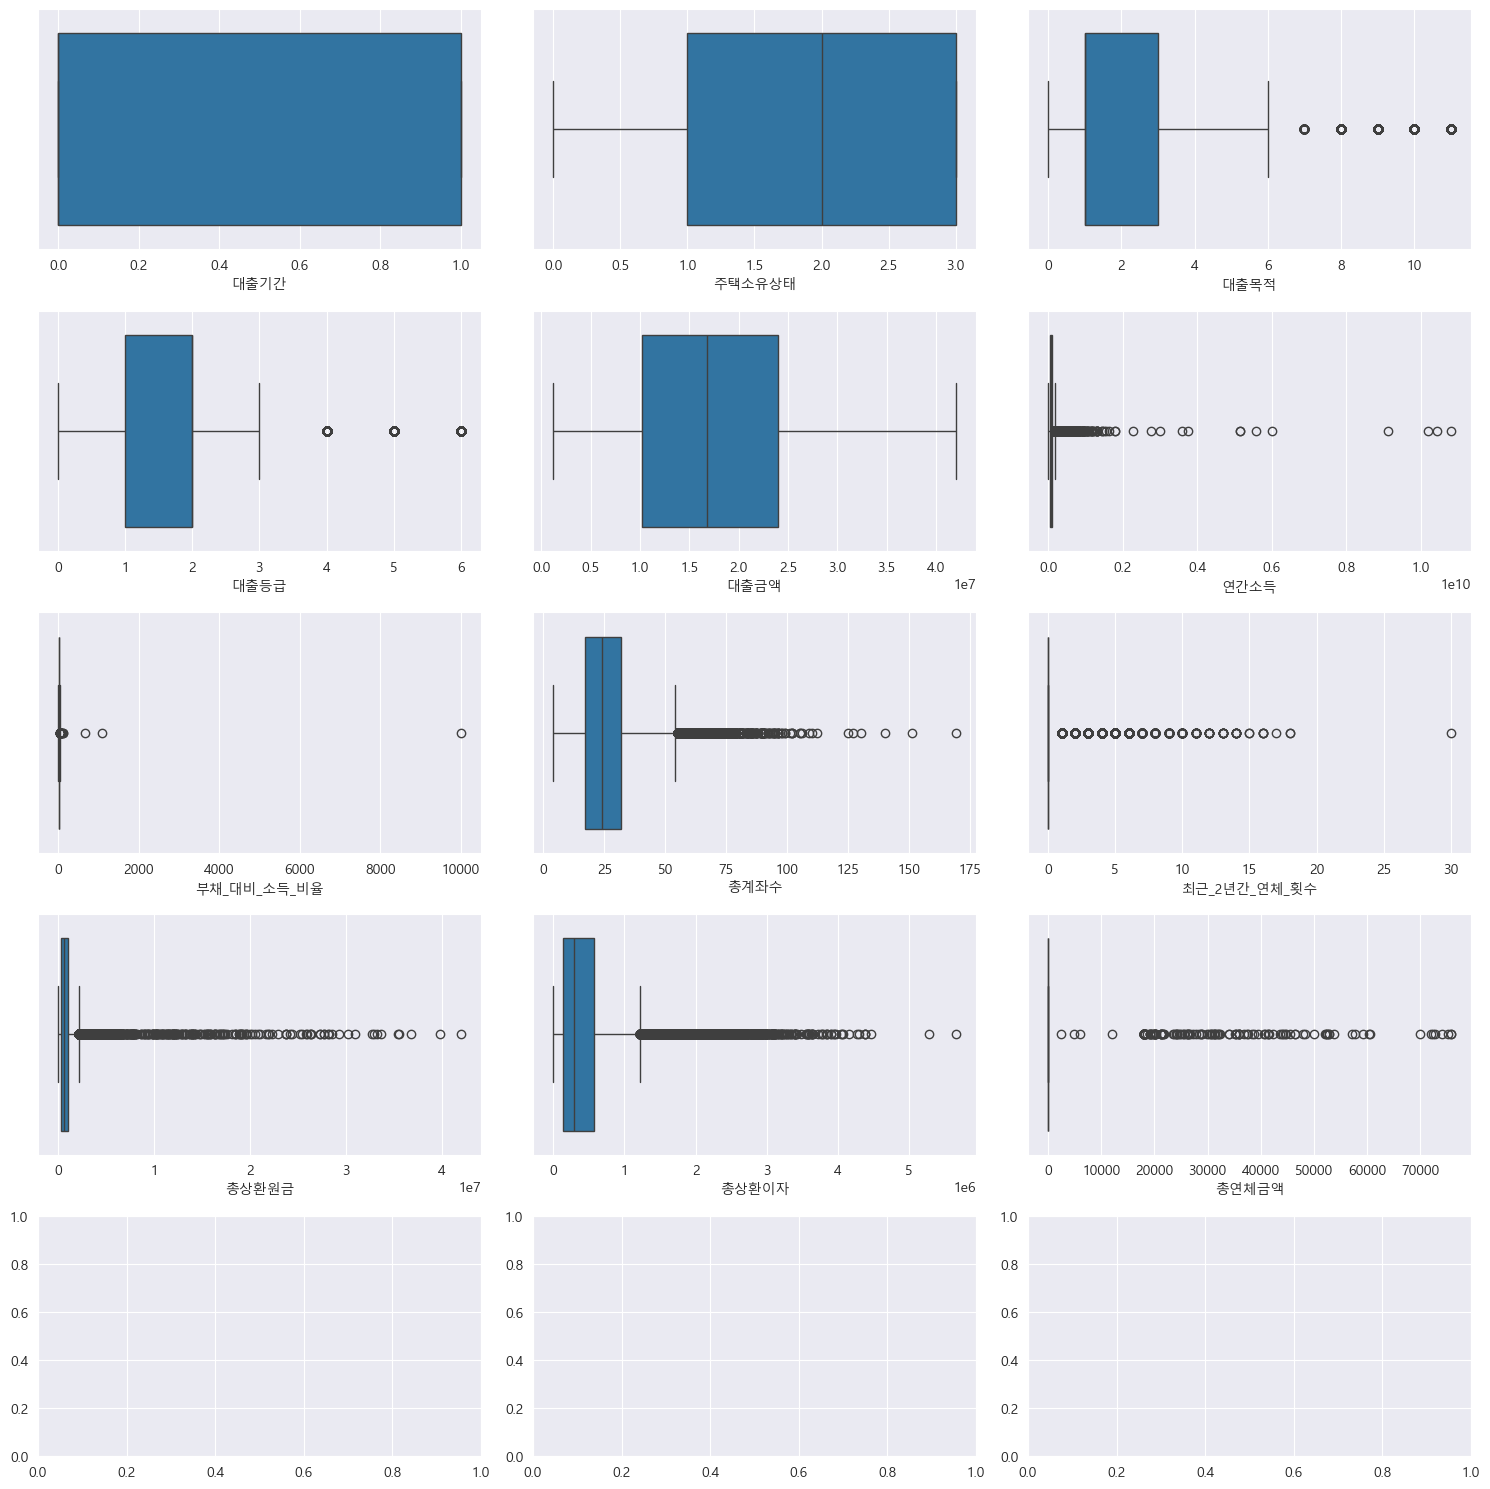

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns

# 수치형 열 리스트
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 4x3 박스플롯 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0

# 각각의 subplot에 박스플롯 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            sns.boxplot(x=numeric_cols[a], data=train, ax=axes[i, j])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

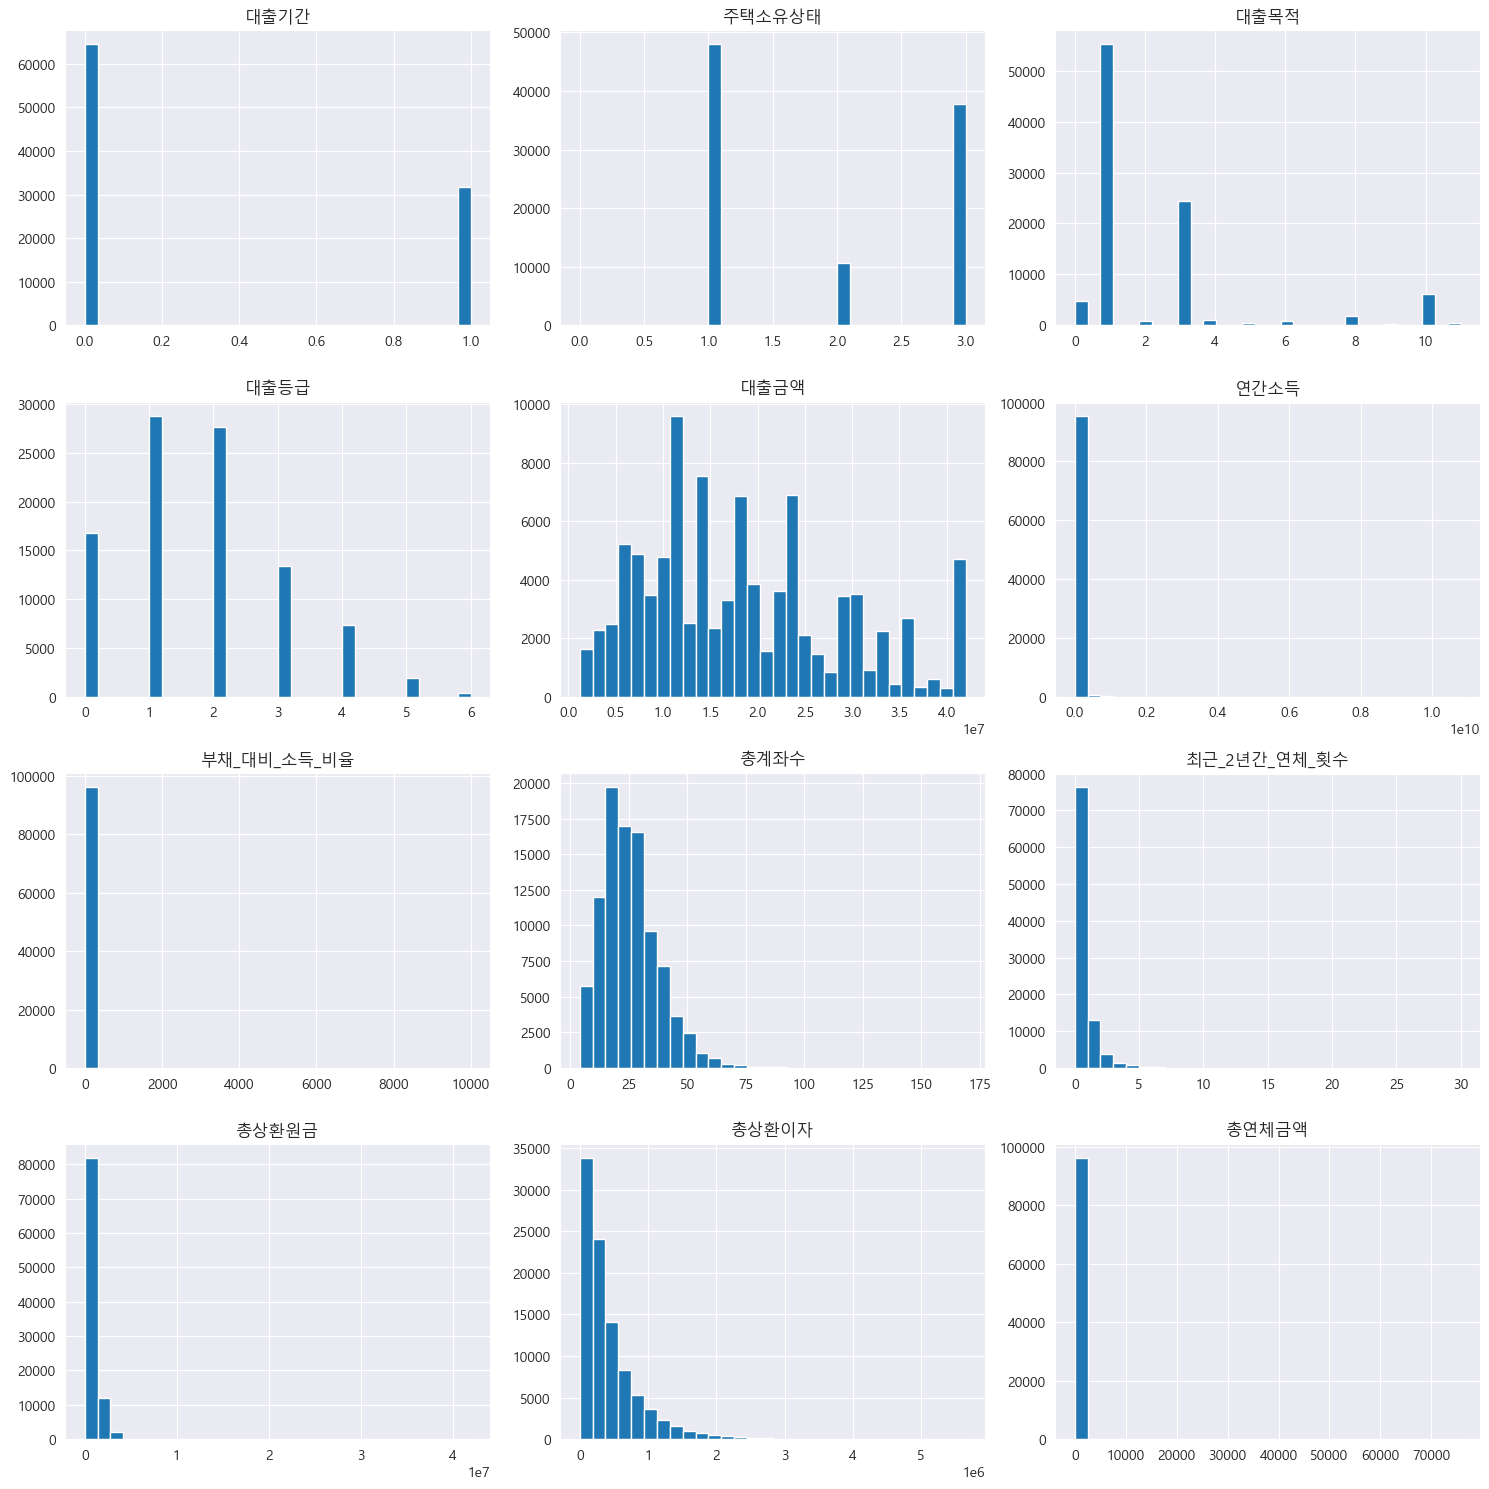

In [81]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(train[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [82]:
import numpy as np

# 로그 변환 적용
train['연간소득'] = np.log1p(train['연간소득'])
train['부채_대비_소득_비율'] = np.log1p(train['부채_대비_소득_비율'])
train['총상환원금'] = np.log1p(train['총상환원금'])
train['총상환이자'] = np.log1p(train['총상환이자'])
train['총연체금액'] = np.log1p(train['총연체금액'])
train['총계좌수'] = np.log1p(train['총계좌수'])
train['최근_2년간_연체_횟수'] = np.log1p(train['최근_2년간_연체_횟수'])
train['총연체금액'] = np.log1p(train['총연체금액'])

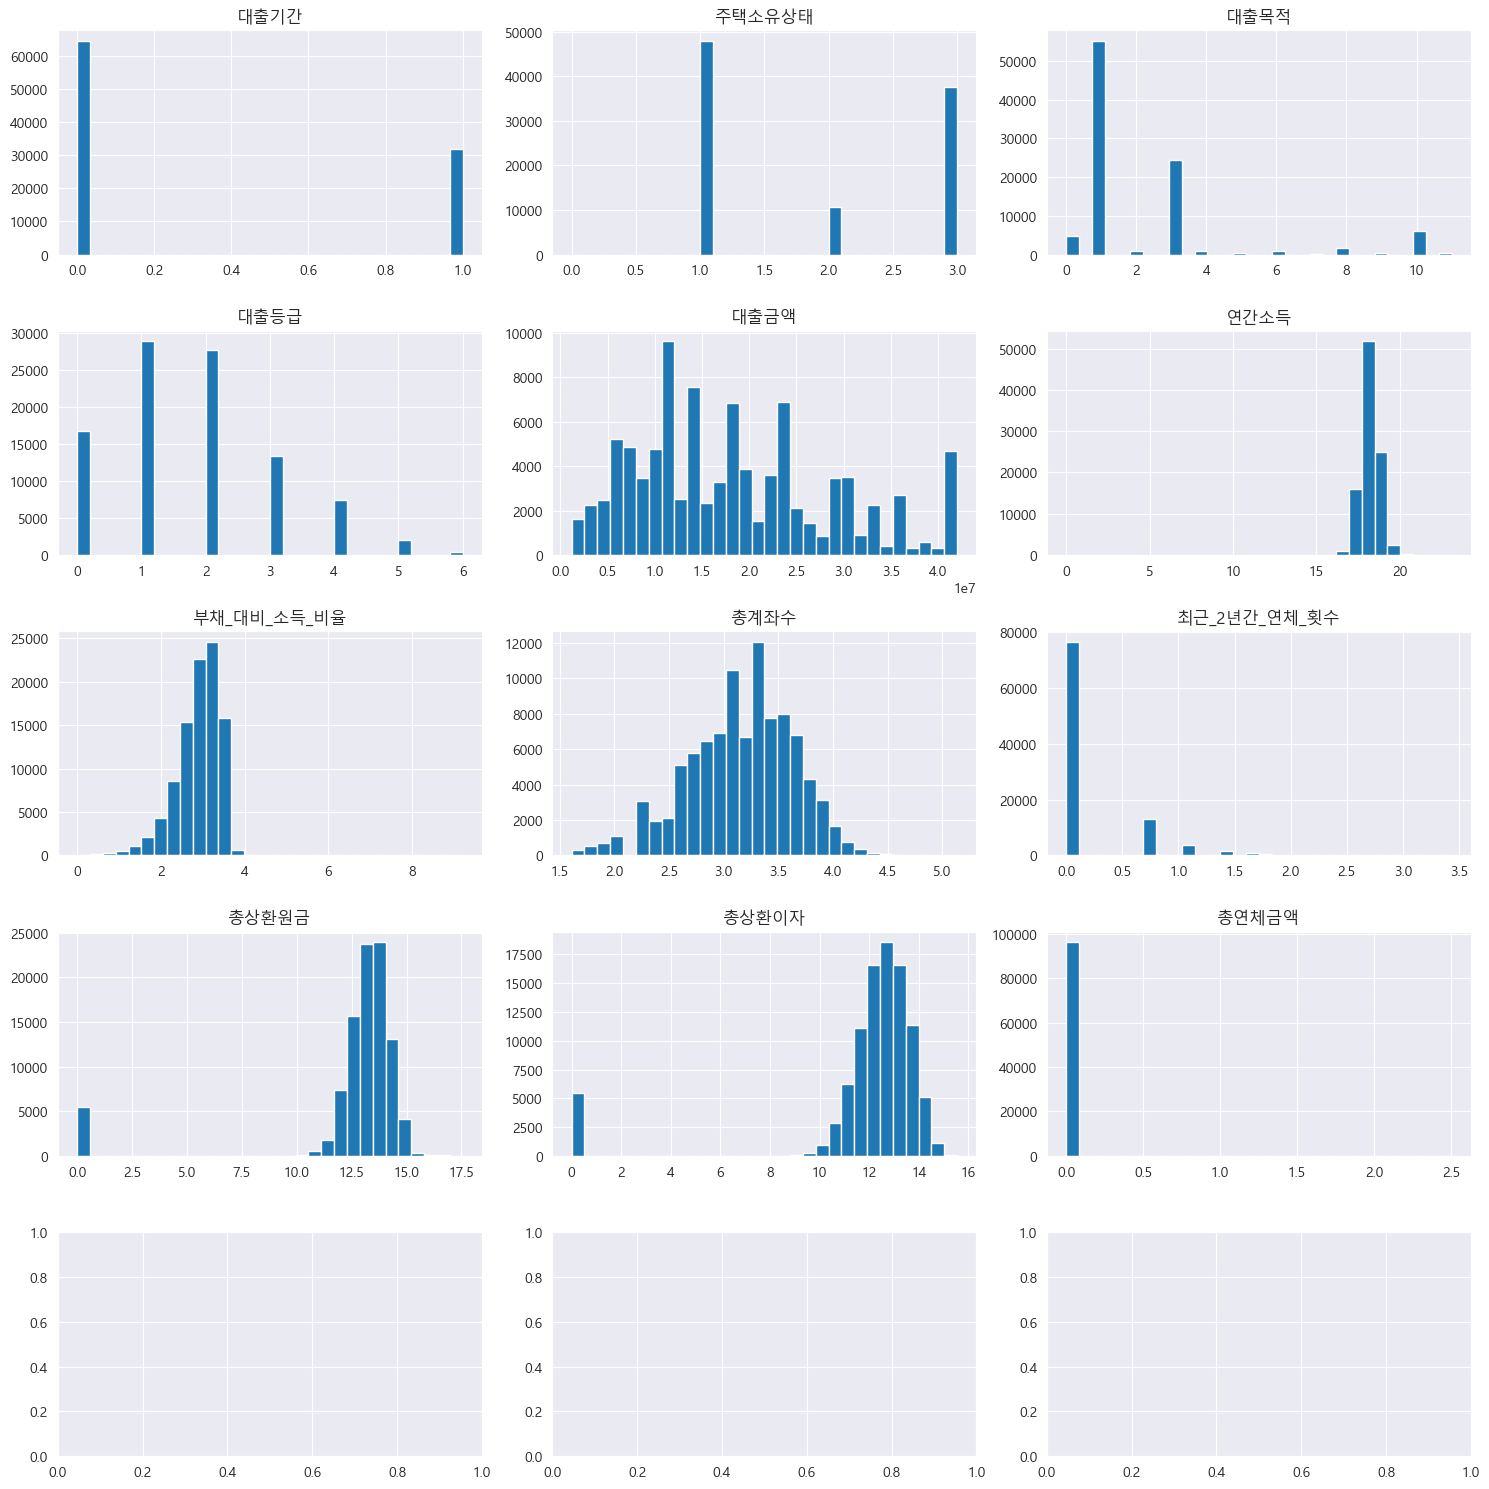

In [83]:
# 4x3 히스토그램 그리기
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
a = 0
numeric_cols = ['대출기간', '주택소유상태','대출목적','대출등급','대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수',
                '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액',
                '연체계좌수']

# 각각의 subplot에 히스토그램 그리기
for i in range(4):
    for j in range(3):
        if a < len(numeric_cols):
            axes[i, j].hist(train[numeric_cols[a]], bins=30)
            axes[i, j].set_title(numeric_cols[a])
            a += 1
        else:
            axes[i, j].set_visible(False)  # 비어있는 서브플롯 숨기기

# 레이아웃 조정
plt.tight_layout()

# 그래프 표시
plt.show()

In [14]:
pred = train[train['근로기간'] == -999]
pred.drop('근로기간', axis = 1 ,inplace = True)

C:\Users\SJ\AppData\Local\Temp\ipykernel_7064\3446293159.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred.drop('근로기간', axis = 1 ,inplace = True)


In [15]:
train_1 = train[train['근로기간'] != -999]

In [16]:
X_train1 = train_1.drop('근로기간',axis=1)
X_train1

,대출금액,대출기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급,근로기간_unknown
0,12480000,0,3,18.092177,2.990720,2.772589,1,0,0.000000,0.000000,0.0,0.0,3,0
1,14400000,1,1,18.689180,3.149740,3.091042,10,0,12.830869,12.363337,0.0,0.0,2,0
2,12000000,0,1,18.379859,2.261763,2.708050,1,0,13.741482,11.931274,0.0,0.0,1,0
3,14400000,0,1,18.698312,2.778198,2.772589,1,0,12.694116,11.938905,0.0,0.0,3,0
5,4800000,0,3,18.246327,2.693275,3.433987,11,0,12.389298,10.922858,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,1,19.162618,2.335052,3.526361,3,0,13.789763,13.106577,0.0,0.0,3,0
96290,28800000,1,1,18.698312,1.818077,3.258097,10,0,13.277192,13.658956,0.0,0.0,5,0
96291,14400000,0,1,18.246327,2.504709,3.135494,3,0,14.213702,12.393535,0.0,0.0,1,0
96292,15600000,0,1,18.010153,2.906901,3.091042,1,2,14.136411,13.614712,0.0,0.0,4,0


In [17]:
y_train1 = train_1['근로기간']
y_train1

0         6.0
1        15.0
2         5.0
3         8.0
5        15.0
         ... 
96289    15.0
96290    15.0
96291     1.0
96292     5.0
96293    15.0
Name: 근로기간, Length: 90623, dtype: float64

In [18]:
# 훈련 세트와 검증 세트로 나누기 (비율 80:20)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train1, y_train1, test_size=0.2, random_state=42)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   대출금액          96294 non-null  int64   
 1   대출기간          96294 non-null  category
 2   근로기간          96294 non-null  float64 
 3   주택소유상태        96294 non-null  category
 4   연간소득          96294 non-null  float64 
 5   부채_대비_소득_비율   96294 non-null  float64 
 6   총계좌수          96294 non-null  float64 
 7   대출목적          96294 non-null  category
 8   최근_2년간_연체_횟수  96294 non-null  int64   
 9   총상환원금         96294 non-null  float64 
 10  총상환이자         96294 non-null  float64 
 11  총연체금액         96294 non-null  float64 
 12  연체계좌수         96294 non-null  float64 
 13  대출등급          96294 non-null  category
 14  근로기간_unknown  96294 non-null  category
dtypes: category(5), float64(8), int64(2)
memory usage: 7.8 MB


In [20]:
# 범주형 특성의 열 인덱스를 찾습니다.
cat_features_index = [X_train.columns.get_loc(col) for col in ['대출기간', '주택소유상태', '대출목적', '대출등급','근로기간_unknown']]

# CatBoost 분류 모델을 생성하고 훈련합니다.
cat_model = CatBoostRegressor(silent=True, iterations=100, cat_features=cat_features_index)
cat_model.fit(X_train, y_train)

In [21]:
cat_predictions = cat_model.predict(X_valid)

In [22]:
# 평균 절대 오차 (MAE) 계산
mae = mean_absolute_error(y_valid, cat_predictions)

# R^2 (결정 계수) 계산
r2 = r2_score(y_valid, cat_predictions)

print(f"MAE: {mae}")
print(f"R^2: {r2}")

MAE: 5.051191992262179
R^2: 0.052566668826668606


In [23]:
# 랜덤 포레스트 회귀 모델을 생성합니다.
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)  # n_estimators는 모델에 사용할 트리의 개수입니다.

# 모델을 훈련 데이터에 맞춥니다.
rf_model.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
# 검증 데이터에 대한 예측을 수행합니다.
rf_predictions = rf_model.predict(X_valid)

# 평균 절대 오차 (MAE)를 계산합니다.
rf_mae = mean_absolute_error(y_valid, rf_predictions)

# 결정 계수 (R^2)를 계산합니다.
rf_r2 = r2_score(y_valid, rf_predictions)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R^2: {rf_r2}")

In [ ]:
len(y_valid)

In [ ]:
type(y_valid)

In [ ]:
type(rf_predictions)

In [ ]:
series = pd.Series(7.75, index=range(18125))

In [ ]:
# 평균 절대 오차 (MAE)를 계산합니다.
rf_mae = mean_absolute_error(y_valid, series)

# 결정 계수 (R^2)를 계산합니다.
rf_r2 = r2_score(y_valid, series)

print(f"Random Forest MAE: {rf_mae}")
print(f"Random Forest R^2: {rf_r2}")

In [23]:
predicted_values_rainfall = cat_model.predict(pred)

In [24]:
predicted_values_rainfall

array([7.7673847 , 5.68073905, 5.79564721, ..., 9.18171022, 8.73453727,
       9.87436309])

In [25]:
train.loc[train['근로기간'] == -999, '근로기간'] = predicted_values_rainfall

In [11]:
train

,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,12480000,0,3.0,3,72000000,18.90,15,1,0,0,0.0,0.0,0.0,2
1,14400000,1,4.0,1,130800000,22.33,21,10,0,373572,234060.0,0.0,0.0,1
2,12000000,0,2.0,1,96000000,8.60,14,1,0,928644,151944.0,0.0,0.0,0
3,14400000,0,3.0,1,132000000,15.09,15,1,0,325824,153108.0,0.0,0.0,2
4,18000000,1,0.0,3,71736000,25.39,19,8,0,228540,148956.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96289,14400000,0,4.0,1,210000000,9.33,33,3,0,974580,492168.0,0.0,0.0,2
96290,28800000,1,4.0,1,132000000,5.16,25,10,0,583728,855084.0,0.0,0.0,4
96291,14400000,0,1.0,1,84000000,11.24,22,3,0,1489128,241236.0,0.0,0.0,0
96292,15600000,0,2.0,1,66330000,17.30,21,1,2,1378368,818076.0,0.0,0.0,3


In [10]:
train.to_csv('../data/train_preprocessing_test.csv', index=False)